####Imports cell

In [1]:
# Object imports
import numpy as np
import pandas as pd
import torch

# Image handle imports
import cv2
from PIL import Image

# Data handle imports
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset

# Others
import random
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt
import os
import zipfile
import random
import io
import time
from pprint import pprint

In [2]:
# check cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The file 'all_data_info.csv' is store all the information about the data we will on our Siamese model.
With Csv reader variable we could investigate the data, and from there decide how to build the model.

In [3]:
# CSV variable
all_data_csv = pd.read_csv('../Data/CSV/all_data_info.csv')
# Look at the first 20 images of the data
all_data_csv.head(20)

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


In [4]:
total_num = len(all_data_csv)
train_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_only'])
test_only_num = len([x for x in all_data_csv["artist_group"].values if x == 'test_only'])
train_and_test_num = len([x for x in all_data_csv["artist_group"].values if x == 'train_and_test'])

artist_num = len(all_data_csv['artist'].unique())
genres_num = len(all_data_csv["genre"].dropna().unique())

pixelsx_mean = all_data_csv["pixelsx"].mean()
pixelsx_var = all_data_csv["pixelsx"].var()
pixelsx_max = int(all_data_csv["pixelsx"].max())
pixelsx_min = int(all_data_csv["pixelsx"].min())

pixelsy_mean = all_data_csv["pixelsy"].mean()
pixelsy_var = all_data_csv["pixelsy"].var()
pixelsy_max = int(all_data_csv["pixelsy"].max())
pixelsy_min = int(all_data_csv["pixelsy"].min())

average_paints_per_artist = all_data_csv['artist'].value_counts().mean()

#print(all_data_csv['artist'].value_counts())
# To check number of images with not NaN genre value
#Nan_genres_num = len(all_data_csv.loc[pd.isna(all_data_csv["genre"]) == False])

print(f'Total number of images in the data: {total_num}')
print(f'The Split of the data between Train only/Train and Test/ Test only is: {train_only_num}/{train_and_test_num}/{test_only_num}\n')

print(f'Number of different genres: {genres_num}')
print(f'Average paints per artist in this set: {average_paints_per_artist:.2f}\n')

print(f'The average size of X axis per image is {pixelsx_mean:.2f} pixel, and average size of Y axis per image is {pixelsy_mean:.2f}')
print(f'The highest (X, Y) measurements are ({pixelsx_max}, {pixelsy_max}), and the lowest are ({pixelsx_min}, {pixelsy_min})')
print(f'The variances of the axis measurements are ({pixelsx_var:.2f}, {pixelsy_var:.2f})')

Total number of images in the data: 103250
The Split of the data between Train only/Train and Test/ Test only is: 14164/86150/2936

Number of different genres: 42
Average paints per artist in this set: 44.52

The average size of X axis per image is 960.81 pixel, and average size of Y axis per image is 984.09
The highest (X, Y) measurements are (25528, 9541), and the lowest are (200, 162)
The variances of the axis measurements are (355538.29, 390799.19)


Presentation of random images from the dataset
Note: Not all the images are presented in their correct color format.

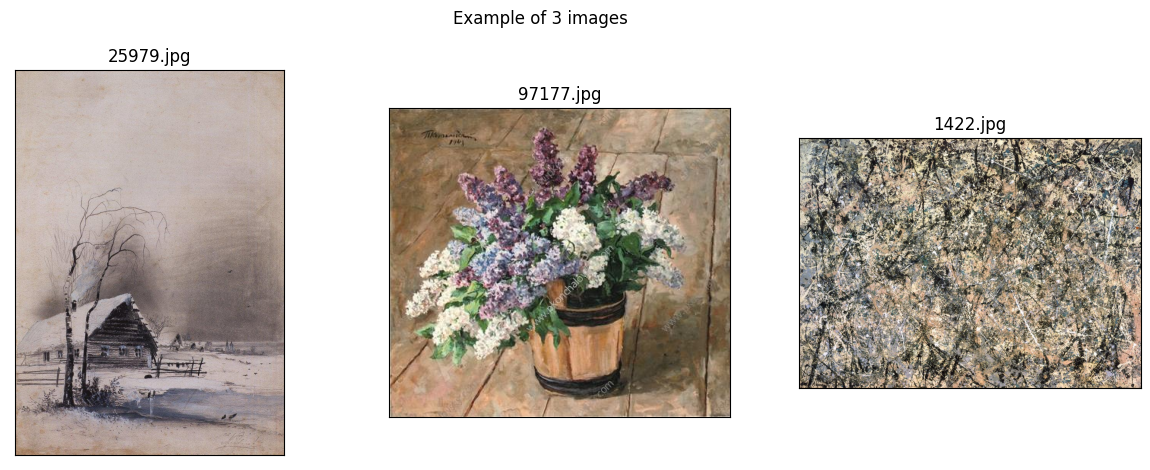

In [8]:
# Example:
img_folder_path = '../Data/Images/training/train'

plt.figure(figsize=(15,5))

for i in range(1,4):
    # choose a image file randomly from the training data
    random_image_name = random.choice(os.listdir(img_folder_path))

    # unzip image with color conversion
    archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
    image_data = archive.open("train/" + random_image_name)
    image = Image.open(image_data)

    # presenting the 3 images in a row
    plt.subplot(1, 3, i)
    plt.title(random_image_name)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.asarray(image))

plt.suptitle(f"Example of {3} images", y=1.001)
plt.show()

This cell I tried different ways to check how to present the image in the correct format color

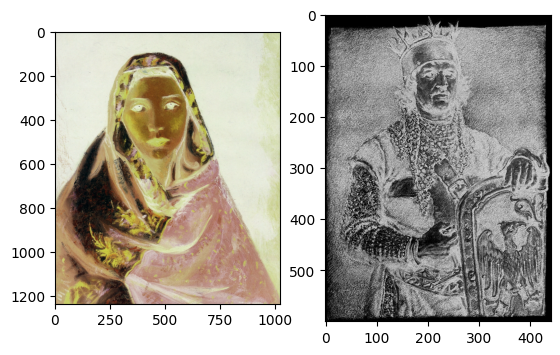

In [22]:
import imghdr
#image = cv2.imread('../Data/Images/training/train/95010.jpg')
#plt.imshow(image)
#plt.show()
try:
    for i in range(1):

        archive = zipfile.ZipFile("../Data/Zips/train.zip", 'r')
        img_path = 'train/'
        #imgdata = archive.open(img_path+'75861.jpg')
        #print(imghdr.what("../Data/Images/training/train/"+'75861.jpg'))
        #print(img.getType())
        #image = Image.open(image_data)
        #print(image.format)
        image = cv2.imread("../Data/Images/training/train/"+"42790.jpg")
        image2 = cv2.imread("../Data/Images/training/train/"+"75861.jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = 255 - image[:,:]
        image2 = 255 - image2[:,:]
        #print(imgdata)
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.subplot(1, 2, 2)
        plt.imshow(image2)
    plt.show()
except Image.DecompressionBombError:
    print("error")
#try:
#    image = cv2.imread('../Data/Images/training/train/72255.jpg')
#    #plt.imshow(image)
#    #plt.show()
#except Image.DecompressionBombError:
#    print("error")

#### Data Loader

First, We should classify our data by train and test data

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# if the data frame is not yet defined we can extract it from files if it is already stored there.
# if the data frame is not saved in files either, we will make it from start
if ("train_data_frame" not in globals()) and (not os.path.isfile("../Data/Variables/train_data_frame.pkl")):
    # We will Train our model only with artists with more than 10 paints in the storage
    paints_per_painter = all_data_csv['artist'].value_counts()
    #a =  all_data_csv.items()
    #paints_per_painter = all_data_csv.items()['artist'].value_counts()
    #print(paints_per_painter)
    actual_artist_list = [paints_per_painter.index[i] for i in range(len(paints_per_painter)) if paints_per_painter[i] > 10]

    # Here we are classifying the data by train and test paints as they registered in the CSV file
    # We take only the paints of the artist with more of 10 paints
    train_data_frame = pd.DataFrame({})
    test_data_frame = pd.DataFrame({})
    i1 = 0
    for artist in actual_artist_list:
        i1 += 1
        artist_data = all_data_csv[(all_data_csv['artist']==artist)]
        artist_train_data = artist_data.loc[(artist_data.in_train == True)]
        artist_test_data = artist_data.loc[(artist_data.in_train == False)]
        train_data_frame = pd.concat([train_data_frame, artist_train_data])
        test_data_frame = pd.concat([test_data_frame, artist_test_data])

    train_data_frame.to_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame.to_pickle("../Data/Variables/test_data_frame.pkl")

else:
    train_data_frame = pd.read_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame = pd.read_pickle("../Data/Variables/test_data_frame.pkl")

data loader class

In [6]:
# An idea is to integrate the SingleDataSet and TripletDataSet with a root class
class SingleDataSet(Dataset):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.train_data_frame = train_data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if Fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"

            self.train_zip_name += '/'
        self.make_data_frame()


        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((res_size, res_size))])

        if is_train:
            self.train_images_files = self.data_frame.iloc[:, 11].values
            self.train_labels = self.data_frame.iloc[:, 0].values
            self.train_index = self.data_frame.index.values


    def make_data_frame(self):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = train_data_frame.loc[train_data_frame['new_filename'].isin(image_name_list)]
        self.data_frame = self.data_frame.reset_index(drop=True)


    def __len__(self):
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three the image and the label
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            # transform the image to a specific dimension
            anchor_image = self.transform(anchor_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            return anchor_image, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, self.res_size, self.res_size), -1


## to debug
#obj = SingleDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i % 1000 == 0:
#        print(f"done {i}")
#
#    i +=1



#nn_data = TripletDataSet("train_1", train_data_frame, 70000)

In [6]:
# inspiration from https://www.kaggle.com/code/spyrosrigas/20-painters-classification-with-cnns-and-svms
class TripletDataSet(Dataset):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.train_data_frame = train_data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if Fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"

            self.train_zip_name += '/'
        self.make_data_frame()


        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((res_size, res_size))])

        if is_train:
            self.train_images_files = self.data_frame.iloc[:, 11].values
            self.train_labels = self.data_frame.iloc[:, 0].values
            self.train_index = self.data_frame.index.values

        self.choose_n_to_visualization(50)

    def make_data_frame(self):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = train_data_frame.loc[train_data_frame['new_filename'].isin(image_name_list)]
        self.data_frame = self.data_frame.reset_index(drop=True)


    def choose_n_to_visualization(self, n):
        indices = np.random.choice(self.train_index, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = self.train_labels[index]

            image = self.transform(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels

    def __len__(self):
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three images per forward sample the 'triplet loss' is relies on
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # case when in sub train group, item don't have a positive partner
            if(len(positive_list) == 0):
                positive_index = index
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            # transform the images to same resolution tensors
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return ret_tensor, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, 3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), -1


## to debug
#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=2, num_workers=0, shuffle=True)
#i = 0
#for inputs, labels in data_loader:
#    #print(inputs.shape)
#    #print(labels)
#    if i == 100:
#        print("done")
#        break
#    i +=1



#nn_data = TripletDataSet("train_1", train_data_frame, 70000)

Tester of data loader speed test

In [12]:
start_time = time.perf_counter()

obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#obj = TripletDataSet("train", train_data_frame, Fixed_res=False)
data_loader = DataLoader(obj, batch_size=32, num_workers=0, shuffle=True)
i = 0
for inputs, labels in data_loader:
    #print(inputs.shape)
    #print(labels)
    if i == 63:
        break
    i += 1
    if i % 10 == 0:
        print(f"done {i}")


end_time = time.perf_counter()
print(f"{end_time - start_time:0.2f} seconds")
#a = obj[2]
#print(obj.__len__())

done 10
done 20
done 30
done 40
done 50
done 60
63.24 seconds


Zip maker

In [6]:
path_from = "../Data/Zips"
path_to = "../Data/Zips/Fixed_Zips"
file_name = "train_1.zip"
images = []
new_res = 256

def resolution_fixture(path_from, path_to, image_store_path, file_name):
    i1 = 0
    archive = zipfile.ZipFile(path_from + '/' + file_name + '.Zip', 'r')
    # first we extract all the filed im a given zip file, and store them in list of items in the form of [file_name, file_in bytes]
    for current_file_path in archive.namelist():
        if (i1) % 500 == 0:
            print(f"{i1} images processed")
        i1 += 1
        # separate the name
        if not "jpg" in current_file_path:
            continue
        else:
            image_name = current_file_path[len(file_name)+1:]

        try:

            file_object = io.BytesIO()
            image_data = archive.open(current_file_path)
            image = Image.open(image_data)
            tensor_image = transforms.Compose([transforms.ToTensor(), transforms.Resize((new_res, new_res))])(image)
            image = transforms.ToPILImage()(tensor_image)
            # save in file object buffer
            image.save(file_object, 'PNG')
            image.close()
            images.append([image_name, file_object])

        except Image.DecompressionBombError:
                print(f"DecompressionBombError in file {image_name}")
        except Exception as e:
            print(f" Error received in image {image_name}")
            print(f" Error massage: {str(e)}")


    #zip_file_bytes_io = io.BytesIO()
    #zip_file = zipfile.ZipFile(path_to + '/' + file_name + '.zip', 'w')

    with zipfile.ZipFile(path_to + '/' + file_name + '_' + str(new_res) + '.zip', 'w') as zip_obj:
        for image_name, bytes_stream in images:
            zip_obj.writestr(file_name + '/' + image_name, bytes_stream.getvalue())
        #pprint(zip_obj.infolist())
resolution_fixture(path_from, path_to, "../Data/Images/Fixed_Resolution","train_1")

499 images processed
999 images processed
1499 images processed
 Error received in image 101947.jpg
 Error massage: image file is truncated (80 bytes not processed)


C:\Users\liorm\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1999 images processed
2499 images processed
2999 images processed
3499 images processed
3999 images processed
4499 images processed
4999 images processed
5499 images processed
5999 images processed
6499 images processed
6999 images processed
7499 images processed
7999 images processed
8499 images processed
8999 images processed
9499 images processed
9999 images processed
10499 images processed
10999 images processed


In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin=100.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.zero_tensor = torch.tensor([0]).to(device)
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)


    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.max(distance_positive - distance_negative + self.margin, self.zero_tensor)
        return losses, predictions


    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.max(distance_positive - distance_negative + self.margin, self.zero_tensor)

        return losses.mean()



In [9]:
class Network(nn.Module):
    def __init__(self, int_dim=3, out_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(int_dim, 32, 6),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, 4),
            nn.PReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(128*28*28, 512),
            nn.PReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.conv(x)
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [10]:
class Network2_(nn.Module):
    def __init__(self, int_dim=3, out_dim=10):
        super(Network2, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(int_dim, 32, 4),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.BatchNorm1d(128*26*26),
            nn.Linear(128*26*26, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.feature_extractor(x)
        #print(x.shape)
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [70]:
from tqdm.notebook import tqdm
epochs=20
batch_size = 2

obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
model = Network2().to(device)
#model.apply(init_weights)
#model = torch.jit.script(model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1/(256**2))
criterion = TripletLoss().to(device)

model.train()
#for epoch in tqdm(range(epochs), desc="Epochs"):
for epoch in range(epochs):
    print(f"start epoch {epoch}")

    running_loss = []
    for step, (inputs, labels) in enumerate(data_loader):
        if((step+1) % 500 == 0):
            break
        anchor_img = inputs[:,0,:,:,:]
        positive_img = inputs[:,1,:,:,:]
        negative_img = inputs[:,2,:,:,:]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))
    test_run(data_loader, model)

start epoch 0
Epoch: 1/20 - Loss: 1044.3661
success rate: 0.51
start epoch 1
Epoch: 2/20 - Loss: 109.2013
success rate: 0.47
start epoch 2
Epoch: 3/20 - Loss: 101.1926
success rate: 0.54
start epoch 3
Epoch: 4/20 - Loss: 105.5670
success rate: 0.52
start epoch 4
Epoch: 5/20 - Loss: 100.5910
success rate: 0.51
start epoch 5
Epoch: 6/20 - Loss: 100.0684
success rate: 0.42
start epoch 6
Epoch: 7/20 - Loss: 102.9625
success rate: 0.46
start epoch 7
Epoch: 8/20 - Loss: 100.7557
success rate: 0.40
start epoch 8
Epoch: 9/20 - Loss: 101.8795
success rate: 0.27
start epoch 9
Epoch: 10/20 - Loss: 100.5650
success rate: 0.12
start epoch 10
Epoch: 11/20 - Loss: 100.0668



KeyboardInterrupt



In [23]:
def test_run(test_loader, model):
    attempts = 0
    successes = 0
    for step, (inputs, labels) in enumerate(test_loader):
        if((step+1) % 500 == 0):
            break
        anchor_img = inputs[:,0,:,:,:]
        positive_img = inputs[:,1,:,:,:]
        negative_img = inputs[:,2,:,:,:]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss, prediction = criterion.predict(anchor_out, positive_out, negative_out)
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]


    print(f"success rate: {(successes / attempts):0.2f}")



#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#model = Network().to(device)
#test_run(data_loader, model)

In [30]:
from torchvision.models import resnet50, ResNet50_Weights



class TripletLoss(nn.Module):
    def __init__(self, margin=0.8):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.zero_tensor = torch.tensor([0]).to(device)
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)


    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.max(distance_positive - distance_negative + self.margin, self.zero_tensor)
        return losses, predictions


    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.max(distance_positive - distance_negative + self.margin, self.zero_tensor)
        if(losses[0] == 0 or losses[1] == 0):
            a = 2

        return losses.mean()

#############################
class Network2(nn.Module):
    def __init__(self, int_dim=3, out_dim=20):
        super(Network2, self).__init__()


        self.feature_extractor_res = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        for param in self.feature_extractor_res.parameters():
            param.requires_grad = True
        self.feature_extractor = nn.Sequential(
            nn.Dropout(0.3),
            nn.BatchNorm2d(3),
            nn.Conv2d(int_dim, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.3),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 9),
            nn.ReLU(),
            nn.Conv2d(64, 64, 9),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.3),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 9),
            nn.ReLU(),
            nn.Conv2d(64, 64, 9),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(0.3),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),


            nn.Flatten()
        )

        self.fc = nn.Sequential(

            nn.Dropout(0.2),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 128),
            nn.ReLU(),

            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, out_dim),
            nn.ReLU(),

            #nn.Dropout(0.2),
            #nn.BatchNorm1d(64),
            #nn.Linear(64, out_dim),
            #nn.ReLU()
        )

    def forward(self, x):
        #print(x.shape)
        x = self.feature_extractor_res(x)
        #print(x.shape)
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x


def test_run(test_loader, model):
    attempts = 0
    successes = 0
    for step, (inputs, labels) in enumerate(test_loader):
        if ((step + 1) % 500 == 0):
            break
        anchor_img = inputs[:, 0, :, :, :]
        positive_img = inputs[:, 1, :, :, :]
        negative_img = inputs[:, 2, :, :, :]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss, prediction = criterion.predict(anchor_out, positive_out, negative_out)
        successes += sum(prediction.cpu()).item()
        attempts += prediction.cpu().shape[0]

    print(f"success rate: {(successes / attempts):0.2f}")


#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
#model = Network().to(device)
#test_run(data_loader, model)





from tqdm.notebook import tqdm
epochs=20
batch_size = 2

obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
data_loader = DataLoader(obj, batch_size=batch_size, num_workers=0, shuffle=True)
model = Network2().to(device)
#model.apply(init_weights)
#model = torch.jit.script(model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
criterion = TripletLoss().to(device)

model.train()
#for epoch in tqdm(range(epochs), desc="Epochs"):
for epoch in range(epochs):
    print(f"start epoch {epoch+1}")
    #for par in torch.optim.param_groups:
    #    print(torch.optim.param_groups[0]['lr'])
    print(optimizer.param_groups[0]['lr'])

    scheduler.step()
    print()
    running_loss = []
    for step, (inputs, labels) in enumerate(data_loader):
        if((step+1) % 500 == 0):
            break
        anchor_img = inputs[:,0,:,:,:]
        positive_img = inputs[:,1,:,:,:]
        negative_img = inputs[:,2,:,:,:]

        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.2f}".format(epoch+1, epochs, np.mean(running_loss)))
    test_run(data_loader, model)

start epoch 1
0.001



C:\Users\liorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch: 1/20 - Loss: 0.91
success rate: 0.55
start epoch 2
0.001

Epoch: 2/20 - Loss: 0.82
success rate: 0.54
start epoch 3
0.0007

Epoch: 3/20 - Loss: 0.78
success rate: 0.60
start epoch 4
0.0007

Epoch: 4/20 - Loss: 0.82
success rate: 0.52
start epoch 5
0.00049

Epoch: 5/20 - Loss: 0.81
success rate: 0.51
start epoch 6
0.00049




KeyboardInterrupt



3-d visualization cell

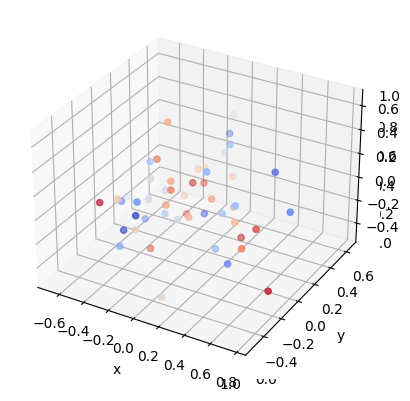

In [9]:
from sklearn.decomposition import PCA


class Network2(nn.Module):
    def __init__(self, int_dim=3, out_dim=10):
        super(Network2, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(int_dim, 32, 4),
            nn.ReLU(),
            nn.Conv2d(32, 32, 4),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 4),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 4),
            nn.ReLU(),
            nn.Conv2d(128, 128, 4),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.BatchNorm1d(128*26*26),
            nn.Linear(128*26*26, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        #print(x.shape)
        x = self.feature_extractor(x)
        #print(x.shape)
        #x = x.view(x.shape[0], -1)
        #print(x.shape)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x







fig = plt.figure()
ax = plt.axes(projection = '3d')
pca = PCA(n_components=3)

def visualization_3d(model, data_object):
    batch_size = 2
    n_images = data_object.n_images
    labels = data_object.labels
    embedded_image_list = np.empty([0, 10])
    for i in range(0, len(n_images), batch_size):
        x = torch.empty((0,3,256,256))
        for j in range(batch_size):
            x = torch.cat([x, n_images[i+j].reshape(1,3,256,256)], 0)
        #x = torch.cat([n_images[i].reshape(1,3,256,256), n_images[i].reshape(1,3,256,256)], 0)
        embedded_image = model(x.to(device))

        embedded_image_list = np.append(embedded_image_list, embedded_image.cpu().detach().numpy(), 0)
    principalComponents = pca.fit_transform(embedded_image_list)


    principalDf =pd.DataFrame(data = principalComponents, columns = ['pc1',  'pc2', 'pc3'])
    labelDf = pd.DataFrame(labels)
    principalDf = pd.concat([principalDf,labelDf],axis = 1,join='inner', ignore_index=True)
    principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
    principalDf.columns = ["pc1", "pc2", "pc3", "label"]


    #fig = plt.figure(figsize=(9, 6))
    # Create 3D container
    ax = plt.axes(projection = '3d')
    # Visualize 3D scatter plot
    #mu = random.rand(100,1);
    unique_labels = principalDf["label"].unique()
    name_to_int = {name: i for i, name in enumerate(set(unique_labels))}
    integers = [name_to_int[name] for name in unique_labels]
    labels_colors = [(i - min(integers))/(max(integers) - min(integers))*255 for i in integers]
    labels_colors_dict = dict(zip(unique_labels, labels_colors))
    name_lengths_list = [labels_colors_dict[labels] for labels in principalDf["label"]]
    ax.scatter3D(principalDf["pc1"], principalDf["pc2"], principalDf["pc3"], c = name_lengths_list,  label=principalDf["label"], cmap='coolwarm')
    # Give labels
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

#obj = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
#data_loader = DataLoader(obj, batch_size=1, num_workers=0, shuffle=True)
#model = Network2().to(device)
#visualization_3d(model, obj)